# Lab04

In this lab 4, we look at Recurrent Neural Networks and Sequence Modelling


*   Recurrent Neural Networks(RNN)
*   Sequence Modelling (Seq2Seq)


In [1]:
import torch
# You can enable GPU here (cuda); or just CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RNN
A **recurrent neural network (RNN)** is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. Temporal means distributed across time. Contrast this to a network distributed across space. This allows it to exhibit temporal dynamic behavior. Derived from feed-forward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.

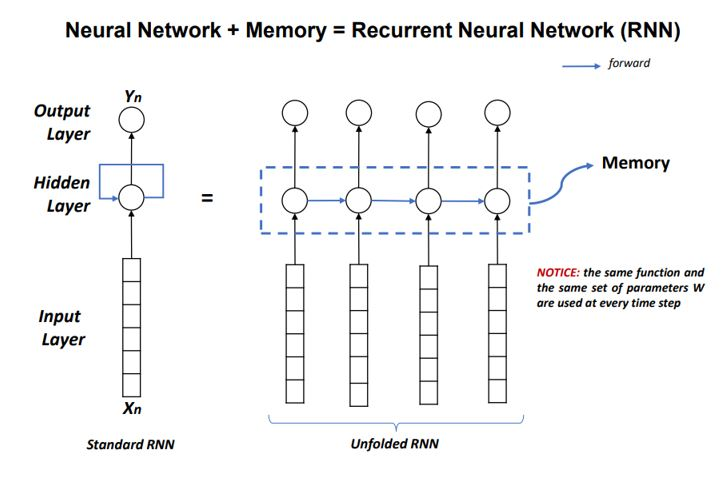


## Predict the last character of the word

In [2]:
# The task is "wor"->"d", "woo" -> "d", "dee" - >"p"

import numpy as np

# Assume that we have the following character instances
char_arr = ['a', 'b', 'c', 'd', 'e', 'f', 'g',
            'h', 'i', 'j', 'k', 'l', 'm', 'n',
            'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']

# for one-hot encoding and decoding 
# {'a': 0, 'b': 1, 'c': 2, ..., 'j': 9, 'k', 10, ...}
num_dic = {n: i for i, n in enumerate(char_arr)}

dic_len = len(num_dic)


# a list of words as sequence data 
seq_data = ['word', 'wood', 'deep', 'dive', 'cold', 'cool', 'load', 'love', 'kiss', 'kind']

# Make a batch to have sequence data for input and ouput
# wor -> X, d -> Y
# dee -> X, p -> Y
def make_batch(seq_data):
    input_batch = []
    target_batch = []
    
    for seq in seq_data:
        # input data is:
        # wor       woo       dee     div      ...
        # [22, 14, 17] [22, 14, 14] [3, 4, 4] [3, 8, 21] ...
        
        input_data = [num_dic[n] for n in seq[:-1]]
        
        # target is :
        # d, d, p, e, ...
        # 3, 3, 15, 4, ...
        target = num_dic[seq[-1]]
        
        # convert input to one-hot encoding.
        # if input is [3, 4, 4]:
        # [[ 0,  0,  0,  1,  0,  0,  0, ... 0]
        #  [ 0,  0,  0,  0,  1,  0,  0, ... 0]
        #  [ 0,  0,  0,  0,  1,  0,  0, ... 0]]
        input_batch.append(np.eye(dic_len)[input_data])
        
        target_batch.append([target])

    return input_batch, target_batch


In [3]:
### Setting hyperparameters

learning_rate = 0.01
n_hidden = 64
total_epoch = 50

# Temporal length of sequences for RNN
n_step = 3

# number of inputs (dimension of input vector) = 26
n_input = dic_len
# number of classes = 26
n_class = dic_len

### Dropout

Dropout makes each hidden unit more robust and drives it towards creating useful features on its own without relying on other hidden units to correct its mistakes


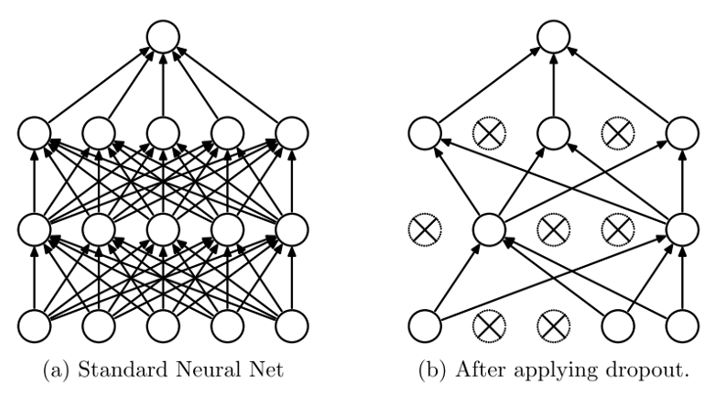

## Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

class RNN_Model(nn.Module):
    def __init__(self):
        super(RNN_Model, self).__init__()
        # RNN layer, the batch_first is False by default, which means the input and output tensors are provided as (seq_len, batch_size, feature) 
        # We need to set it to True because we are using input of shape (batch_size, seq_len, feature)  
        # By setting num_layer=2, we will stack two RNNs (layers) together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results
        # Apply dropout (=0.2) to prevent overfitting, you can try to change the dropout rate. Note that this dropout is applied on outputs of each RNN layer except the last layer
        # More details about nn.RNN, please refer to: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.rnn = nn.RNN(n_input, n_hidden, num_layers=2, batch_first=True, dropout=0.2)
        # Linear layer for output
        self.linear = nn.Linear(n_hidden, n_class)

    def forward(self, x):
        # There are two outputs from nn.RNN:
        # 1. tensor of shape (batch_size, seq_len, hidden_size) containing the output features from the last layer of the RNN for each time step t
        # 2. tensor of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # Here we only care about the first output. Details for the two outputs can be found in PyTorch documentation for nn.RNN: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN
        rnn_output, h_n = self.rnn(x)
        # print("rnn_output:", rnn_output.shape)
        # Here we extract only the last hidden state from the RNN output features
        # The last hidden state carries the information about what the RNN cell has seen over time. 
        # Thus the prediction based on the last hidden state not only considers the data at the current time step, instead, it considers historical data.
        x_last = rnn_output[:,-1,:] 
        # print(n_hidden, n_class)
        # print(x_last.shape)
        x = self.linear(x_last)
        return x

# Set the model to GPU
model = RNN_Model().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Preparing input
input_batch, target_batch = make_batch(seq_data)
# Convert input into tensors and set them to GPU by using tensor.to(device)
input_batch_torch = torch.from_numpy(np.array(input_batch)).float().to(device)
target_batch_torch = torch.from_numpy(np.array(target_batch)).view(-1).to(device)

for epoch in range(total_epoch):  
    
    # Set the flag to training mode
    model.train()
    
    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(input_batch_torch) 
    loss = criterion(outputs, target_batch_torch)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs, 1)
    
    acc= accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    print('Epoch: %d, loss: %.5f, train_acc: %.2f' %(epoch + 1, loss.item(), acc))

print('Finished Training')

## Prediction

# Set the flag to evaluation mode, which will 'turn off' the dropout
model.eval()
outputs = model(input_batch_torch) 
_, predicted = torch.max(outputs, 1) # same as predicted = torch.argmax(pred_outputs, 1)

predict_words = []
for i in range(len(predicted.cpu().numpy())):
    ind = predicted.cpu().numpy()[i]
    predict_words.append(seq_data[i][:-1]+char_arr[ind])

print('\n=== Prediction Result ===')
print('Input:', [w[:3] + ' ' for w in seq_data])
print('Predicted:', predict_words)
print('Accuracy: %.2f' %acc)


Epoch: 1, loss: 3.21997, train_acc: 0.00
Epoch: 2, loss: 2.70871, train_acc: 0.50
Epoch: 3, loss: 1.99028, train_acc: 0.50
Epoch: 4, loss: 1.54771, train_acc: 0.50
Epoch: 5, loss: 1.45775, train_acc: 0.50
Epoch: 6, loss: 1.33956, train_acc: 0.50
Epoch: 7, loss: 1.35080, train_acc: 0.40
Epoch: 8, loss: 1.29566, train_acc: 0.50
Epoch: 9, loss: 1.26782, train_acc: 0.50
Epoch: 10, loss: 1.18613, train_acc: 0.60
Epoch: 11, loss: 1.08898, train_acc: 0.60
Epoch: 12, loss: 0.97741, train_acc: 0.70
Epoch: 13, loss: 0.89192, train_acc: 0.70
Epoch: 14, loss: 0.80376, train_acc: 0.70
Epoch: 15, loss: 0.73815, train_acc: 0.80
Epoch: 16, loss: 0.67846, train_acc: 0.70
Epoch: 17, loss: 0.59961, train_acc: 0.80
Epoch: 18, loss: 0.53090, train_acc: 0.90
Epoch: 19, loss: 0.46214, train_acc: 0.90
Epoch: 20, loss: 0.38952, train_acc: 0.90
Epoch: 21, loss: 0.42817, train_acc: 0.90
Epoch: 22, loss: 0.30031, train_acc: 0.90
Epoch: 23, loss: 0.30009, train_acc: 0.90
Epoch: 24, loss: 0.27623, train_acc: 0.90
E

# Seq2Seq Model (N to M)

Seq2seq turns one sequence into another sequence. It does so by use of a recurrent neural network (RNN) or more often LSTM or GRU to avoid the problem of vanishing gradient. The context for each item is the output from the previous step. The primary components are one encoder and one decoder network. The encoder turns each item into a corresponding hidden vector containing the item and its context. The decoder reverses the process, turning the vector into an output item, using the previous output as the input context


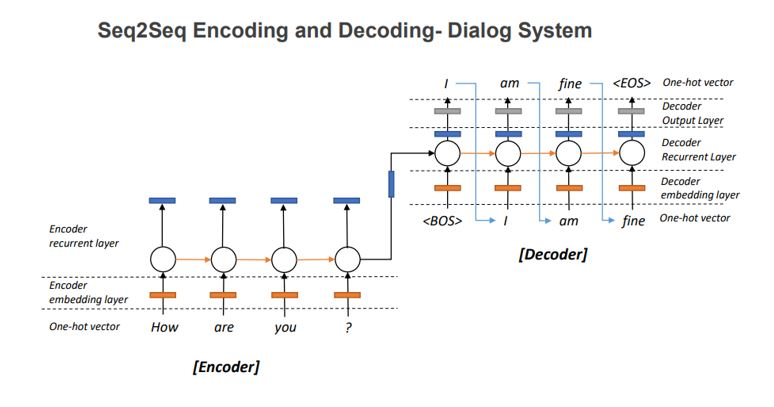


We are going to implement a sequence to sequence model that translates playing card symbols (Ace, Jack, Queen, King) to their associated number.

## Preprocess data

In [5]:
# Task is "ace" -> "01", "jack" -> "11",  a sequence to sequence problem with teacher forcing

import torch
import numpy as np


# Sequence data
seq_data = [['ace', '01'], ['jack', '11'],
            ['queen', '12'], ['king', '13']]

# Generate unique tokens list
chars = []
for seq in seq_data:    
    chars += list(seq[0])
    chars += list(seq[1])

# To simplify the question, we put all characters (including input and output) into one set
char_arr = list(set(chars))

# special tokens are required
# B: Beginning of Sequence
# E: Ending of Sequence
# P: Padding of Sequence - for different size input
# U: Unknown element of Sequence - for different size input
char_arr.append('B')
char_arr.append('E')
char_arr.append('P')
char_arr.append('U')

num_dic = {n: i for i, n in enumerate(char_arr)}

dic_len = len(num_dic)

max_input_words_amount = 5
max_output_words_amount = 3

## Generate batch

In [6]:
# add paddings if the word is shorter than the maximum number of words
def add_paddings(word, max_num=5):
    diff = max_num - len(word)
    return word+'P'*diff
    

# generate a batch data for training/testing
def make_batch(seq_data):
    encoder_input_batch = []
    decoder_input_batch = []
    target_batch = []

    for seq in seq_data:
        # Input for encoder cell, convert to vector
        input_word = add_paddings(seq[0])
        en_input_data = [num_dic[n] for n in input_word]
        
        # Input for decoder cell, Add 'B' at the beginning of the sequence data
        de_input_data  = [num_dic[n] for n in ('B'+ seq[1])]
        
        # Output of decoder cell (Actual result), Add 'E' at the end of the sequence data
        # Since the length of target is fixed, actually we don't need to add "E" in the end
        # However, for uncertain target length, 'E' is important since we need to stop when it comes to "E" during the prediction
        target = [num_dic[n] for n in (seq[1] + 'E')]

        # Convert each character vector to one-hot encoding data
        encoder_input_batch.append(np.eye(dic_len)[en_input_data])
        decoder_input_batch.append(np.eye(dic_len)[de_input_data])
        
        target_batch.append(target)
        

    return encoder_input_batch, decoder_input_batch, target_batch

## Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score



class Seq2Seq_Model(nn.Module):
    def __init__(self):
        super(Seq2Seq_Model, self).__init__()

        # RNN encoder.
        self.rnn_encoder = nn.RNN(n_input, n_hidden, batch_first= True)

        # Drop out can be applied as a layer (on output of RNN see below in forward()). 
        # Previously we applied it as a parameter of nn.RNN layer ('dropout=0.2')
        self.dropout_encoder = nn.Dropout(0.1)
        
        # RNN decoder
        self.rnn_decoder = nn.RNN(n_input, n_hidden, batch_first= True)
        self.dropout_decoder = nn.Dropout(0.1)
        self.linear = nn.Linear(n_hidden,n_class)

    def forward(self, x_encoder, x_decoder):

        # "hidden" containing the hidden state for t = seq_len.
        _,hidden = self.rnn_encoder(x_encoder)
        # Applying dropout layer on output of RNN
        hidden = self.dropout_encoder(hidden)

        # [IMPORTANT] Setting "hidden" as inital_state of rnn_decoder
        decoder_output,_ = self.rnn_decoder(x_decoder,hidden)
        # Applying dropout layer on output of RNN
        decoder_output = self.dropout_decoder(decoder_output)

        # prediction_output_before_softmax = self.linear(decoder_output)
        # output_after_softmax = torch.log_softmax(prediction_output_before_softmax,dim=-1)
        # Since nn.CrossEntropyLoss combines LogSoftmax and NLLLoss for us, we only need the prediction_output_before_softmax
        output = self.linear(decoder_output)
        
        return output


### Setting Hyperparameters
learning_rate = 0.01
n_hidden = 128
total_epoch = 200

n_class = dic_len
n_input = dic_len

model = Seq2Seq_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

encoder_input_batch, decoder_input_batch, target_batch = make_batch(seq_data)
encoder_input_torch = torch.from_numpy(np.array(encoder_input_batch)).float().to(device)
decoder_input_torch = torch.from_numpy(np.array(decoder_input_batch)).float().to(device) 
target_batch_torch = torch.from_numpy(np.array(target_batch)).view(-1).to(device)

for epoch in range(total_epoch):  # loop over the dataset multiple times
   
    model.train()
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(encoder_input_torch,decoder_input_torch) 
    loss = criterion(outputs.view(-1,outputs.size(-1)), target_batch_torch)
    loss.backward()
    optimizer.step()

    if epoch%10==9:
        print('Epoch: %d, loss: %.5f' %(epoch + 1, loss.item()))

print('Finished Training')

Epoch: 10, loss: 0.48932
Epoch: 20, loss: 0.28464
Epoch: 30, loss: 0.08302
Epoch: 40, loss: 0.01305
Epoch: 50, loss: 0.00536
Epoch: 60, loss: 0.00204
Epoch: 70, loss: 0.00150
Epoch: 80, loss: 0.00100
Epoch: 90, loss: 0.00081
Epoch: 100, loss: 0.00090
Epoch: 110, loss: 0.00047
Epoch: 120, loss: 0.00057
Epoch: 130, loss: 0.00058
Epoch: 140, loss: 0.00062
Epoch: 150, loss: 0.00035
Epoch: 160, loss: 0.00030
Epoch: 170, loss: 0.00026
Epoch: 180, loss: 0.00037
Epoch: 190, loss: 0.00028
Epoch: 200, loss: 0.00023
Finished Training


## Evaluation

In [8]:
def predict(word):
    # add padding
    word = add_paddings(word, max_input_words_amount)
    
    # Setting each character of predicted as 'U' (Unknown) 
    # ['king'(padded), 'UU']
    seq_data = [word, 'U' * 2]


    # predict first token
    encoder_input_batch, decoder_input_batch, _ = make_batch([seq_data])
    encoder_input_torch = torch.from_numpy(np.array(encoder_input_batch)).float().to(device)   
    decoder_input_torch = torch.from_numpy(np.array(decoder_input_batch)).float().to(device)

    model.eval()
    outputs = model(encoder_input_torch,decoder_input_torch) 
    predicted = torch.argmax(outputs, -1) 
    first_token = char_arr[predicted.cpu().numpy()[0][0]]

    # predict second token
    seq_data[1] = first_token + 'U'

    encoder_input_batch, decoder_input_batch, _ = make_batch([seq_data])
    encoder_input_torch = torch.from_numpy(np.array(encoder_input_batch)).float().to(device)   
    decoder_input_torch = torch.from_numpy(np.array(decoder_input_batch)).float().to(device)

    model.eval()
    outputs = model(encoder_input_torch,decoder_input_torch) 
    predicted = torch.argmax(outputs, -1) 
    second_token = char_arr[predicted.cpu().numpy()[0][1]]

    return first_token + second_token
    
print('=== Prediction result ===')
print('ace ->', predict('ace'))
print('jack ->', predict('jack'))
print('queen ->', predict('queen'))
print('king ->', predict('king'))


=== Prediction result ===
ace -> 01
jack -> 11
queen -> 12
king -> 13


# Exercise





##E1. Briefly describe the advantage of Bi-RNN over vanilla RNN.
Please write down your answer below in your own words. 

Your answer:

## E2. (Text classification using Bi-RNN)

In this exercise, you are going to implement a **Bi-RNN model** to perform a text classification task. Please notice that we have already done the preprocessing and embedding part of the dataset (The preprocessing is provided in the [Extension section](#scrollTo=3OSJFmG1C6HW)). You only need to focus on the Model part.

Tips: [torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) that we used in the sections above can implement Bi-RNN by simpling setting the 'bidirectional' parameter to True. 




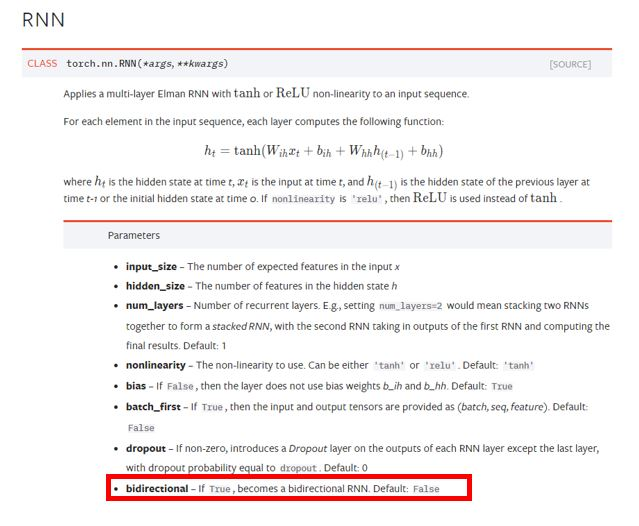

Using Bi-RNN, we will concatenate the forward and backward last hidden state for final prediction. The forward and backward last hidden state can be extracted from the *h_n* in the second returned value of torch.nn.RNN. You can implement it by concatenating last hidden states from both forward and backward RNN layer (using [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html)).

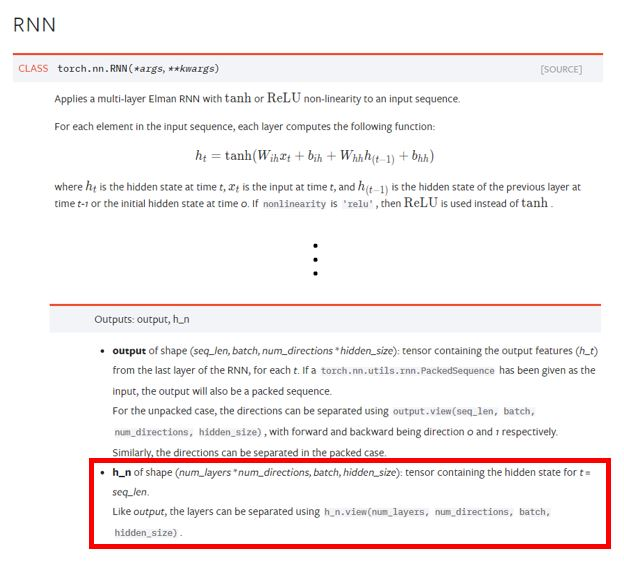

### Downloading dataset

In [9]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '16bT0gkTI3EEemyi-6rMaZ-bJHfsCbFGU'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('embedded_docs.pkl')  

id = '1xjgvacGXn5hSWERBw5zTAFtHessESCb-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labels.pkl')  

import pickle
input_embeddings = pickle.load(open("embedded_docs.pkl","rb"))
label = pickle.load(open("labels.pkl","rb"))

### Split the dataset

In [10]:
# Split into training and testing dataset using scikit-learn
# For more details, you can refer to: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split
train_embeddings, test_embeddings, train_label, test_label = train_test_split(input_embeddings,label,test_size = 0.2, random_state=0)

# The processed data has the shape of (data_size, sequence_length, embedding_dimension)
print(train_embeddings.shape)
print(train_label.shape)

(1805, 512, 25)
(1805,)


### Model (please complete the following sections)

**NOTE**: By updating hyperparameters, you should achieve **at least 0.4** for testset "weighted avg" f1. (There will be randomness in the training process, so tutors would run your code several times and there should be at least one of the output reaching 0.4)

***What is F1?***


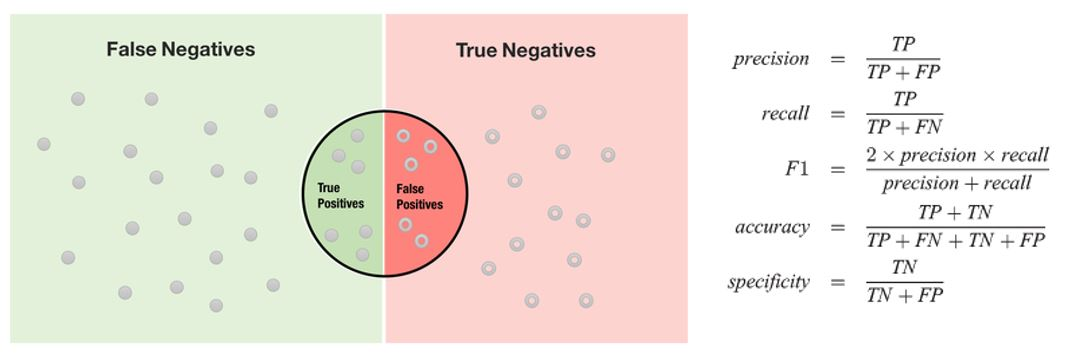

In [11]:
import torch
# You can enable GPU here (cuda); or just CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # Please complete the code for the modeling part
        self.rnn = nn.RNN(n_input, n_hidden, bidirectional=True, batch_first=True)
        # Linear layer for output
        # Bi-Directional therefore twice the number of hidden layers (forward + backwards)
        # i.e. hidden layers * directions (2, since forward and backwards)
        self.linear = nn.Linear(n_hidden*2, n_class)


    def forward(self, x):        
        # Please complete the code for forward propagation
        rnn_output, h_n = self.rnn(x)

        # get the forward hidden states of the last interval
        # forward_hidden_states = rnn_output[:,-1,:n_hidden]
        forward_hidden_states = h_n[0,:,:]

        # get the backwards hidden states from first interval
        # backward_hidden_states = rnn_output[:,0,n_hidden:]
        backward_hidden_states = h_n[1,:,:]

        # concatenate both hidden sates to get full hiddens states.
        full_h_n = torch.cat((forward_hidden_states, backward_hidden_states), dim = 1)

        # pass value of hidden states at last interval of both forward and backwards
        x = self.linear(full_h_n)

        # Debugging
        # print("1 Last rnn:",rnn_output[:,-1,:n_hidden])
        # print("2 Last rnn:",rnn_output[:,0,n_hidden:])
        # print("Full h_n:",h_n.shape)
        # print("Forward rnn:",h_n[0,:,:])
        # print("Backward rnn:",h_n[-1,:,:])
        # print("Concat:", torch.cat((h_n[0,:,:], h_n[-1,:,:]), dim = 1))
        # print("RNN output:", rnn_output.shape)
        # # print("Linear:", n_hidden*2, n_class)
        return x

In [13]:
import numpy as np
import torch.optim as optim

# Please assign values to these variables by using other variables (instead of hard code)

# This should be the length of each sequence
seq_length = train_embeddings.shape[1]

# This should be the input feature dimension
n_input = train_embeddings.shape[2]

# This should be the number of class
n_class = np.unique(train_label).shape[0]

# Please decide the hyperparameters here by yourself
n_hidden = 250
batch_size = 250
total_epoch = 25
learning_rate = 0.001

# Print paramaters
print("learning_rate:", learning_rate)
print("seq_length:", seq_length)
print("n_input:", n_input)
print("n_class:", n_class)
print("n_hidden:", n_hidden)
print("batch_size:", batch_size)
print("total_epoch:", total_epoch)


learning_rate: 0.001
seq_length: 512
n_input: 25
n_class: 4
n_hidden: 250
batch_size: 250
total_epoch: 25


In [14]:
from sklearn.metrics import accuracy_score

model = Bi_RNN_Model().to(device)
criterion = nn.CrossEntropyLoss()

# Please find which optimizer provides a higher f1
# Adam gives higher f1 than SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,train_embeddings.shape[0],batch_size):
        input_batch = train_embeddings[ind:min(ind+batch_size, train_embeddings.shape[0])]
        target_batch = train_label[ind:min(ind+batch_size, train_embeddings.shape[0])]
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device)
        # print("Input_Batch:", input_batch_torch.shape)
        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch) 
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    print('Epoch: %d, train loss: %.5f'%(epoch + 1, train_loss))

print('Finished Training')

## Prediction
model.eval()
outputs = model(torch.from_numpy(test_embeddings).float().to(device)) 
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
# The returned report includes the 'weighted avg f1' we want (refer to the sample output)
# More details can be found from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(test_label, predicted.cpu().numpy(),digits=4))

Epoch: 1, train loss: 10.83886
Epoch: 2, train loss: 10.19120
Epoch: 3, train loss: 9.51244
Epoch: 4, train loss: 8.93592
Epoch: 5, train loss: 8.32743
Epoch: 6, train loss: 7.87628
Epoch: 7, train loss: 7.42309
Epoch: 8, train loss: 7.14651
Epoch: 9, train loss: 6.59029
Epoch: 10, train loss: 6.31171
Epoch: 11, train loss: 6.34815
Epoch: 12, train loss: 5.51343
Epoch: 13, train loss: 5.03448
Epoch: 14, train loss: 4.69132
Epoch: 15, train loss: 4.54490
Epoch: 16, train loss: 5.46581
Epoch: 17, train loss: 5.58032
Epoch: 18, train loss: 4.71100
Epoch: 19, train loss: 4.17191
Epoch: 20, train loss: 3.80137
Epoch: 21, train loss: 4.42135
Epoch: 22, train loss: 4.72238
Epoch: 23, train loss: 4.42385
Epoch: 24, train loss: 4.52236
Epoch: 25, train loss: 4.64764
Finished Training
              precision    recall  f1-score   support

           0     0.6106    0.7419    0.6699        93
           1     0.9359    0.5984    0.7300       122
           2     0.7439    0.5596    0.6387       1

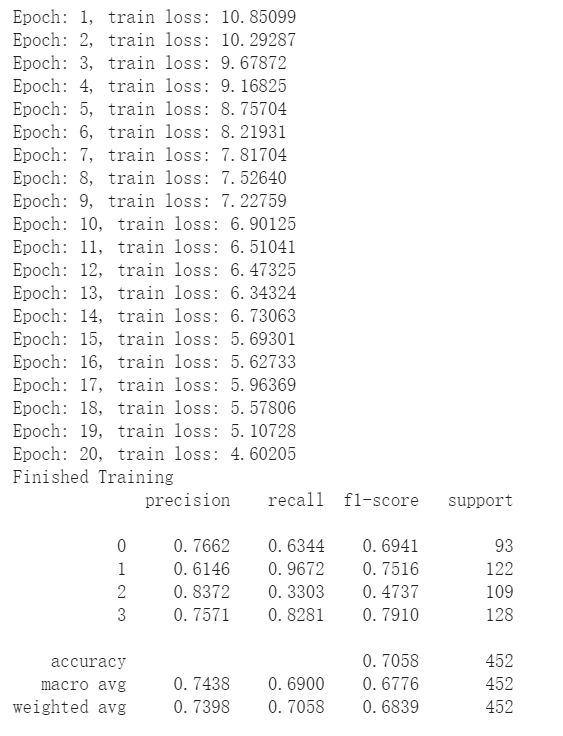

# Extension for Lab04: Preprocessing of Exercise Dataset

We have preprocessed the exercise data collected from [sklearn.datasets "fetch_20newsgroups"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html), `'alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med'`. We removed some special characters (you can refer to the `clean_str` function below). We have set the maxmum sentence length as 512 (`maxlength` = 512).  

In [7]:
import re
import gensim.downloader as api
import numpy as np

In [8]:
model = api.load("glove-twitter-25")  # download the model and return as object ready for use

[==================================================] 100.0% 104.8/104.8MB downloaded


In [9]:
from sklearn.datasets import fetch_20newsgroups # collect 4 types of news data
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)

KeyboardInterrupt: ignored

In [ ]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [ ]:
doc_length_list = []
for doc in twenty_train.data:
    doc_length_list.append(len(clean_str(doc).split()))

In [ ]:
maxlength = 512

In [ ]:
import matplotlib.pyplot as plt

plt.hist(doc_length_list, 200, range=(0,4000))
plt.axvline(x=maxlength,color="red",dashes=[5,2])
plt.show()

In [ ]:
embedded_docs = []
for doc in twenty_train.data:
    embedded_doc = []
    tokenized_doc = clean_str(doc).split()
    for i in range(maxlength):
        if i == len(tokenized_doc):
            for j in range(maxlength-i):
                embedded_doc.append([0]*25)
            break
        else:
            try:
                embedded_doc.append(model.wv[tokenized_doc[i]])
            except:
                embedded_doc.append([0]*25)
    
    embedded_docs.append(embedded_doc)

In [ ]:
embedded_docs = np.array(embedded_docs)
print(embedded_docs.shape)
labels = np.asarray(twenty_train.target)
print(labels.shape)

In [ ]:
import pickle
# write to cPickle
pickle.dump(embedded_docs, open( "embedded_docs.pkl", "wb" ) )
pickle.dump(labels, open( "labels.pkl", "wb" ) )